In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# you can choose one of the following package for image reading/processing
import cv2
import PIL

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Classification Problem

## Load Data

In [4]:
class_Name = ['a','b','c','d','e','f','g','h']
class_Num = 8
img_Num = 128
feature_Size = 784 # (28*28)

x_train = np.zeros([1, feature_Size+class_Num])
x_test = np.zeros([1, feature_Size+class_Num])

tmp = np.eye(class_Num)
for i in class_Name:
  data_x = np.zeros([1,feature_Size+class_Num])
  for j in range(0,img_Num):
    img_path = '/content/drive/MyDrive/ML/hw2/EMNIST/' + '{i_class}/{j_img}.jpg'.format(i_class=i,j_img=j)
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE).reshape(1, feature_Size) # (28,28,3) -> (1, 784)           
    # normalize
    img = (img / 255.0)
    img = np.hstack((img, tmp[class_Name.index(i)].reshape(1,8))) # 1-of-K binary coding scheme
    data_x = np.vstack((data_x, img))
  data_x = data_x[1:,:]
  np.random.shuffle(data_x)
  x_train = np.vstack((x_train, data_x[0:96,:]))
  x_test = np.vstack((x_test, data_x[96:128,:]))

y_train = x_train[1:,feature_Size:]
y_test = x_test[1:,feature_Size:]
x_train = x_train[1:,:-8]
x_test = x_test[1:,:-8]

print("training data")
print(x_train.shape)
print(y_train.shape)
print("testing data")
print(x_test.shape)
print(y_test.shape)


training data
(768, 784)
(768, 8)
testing data
(256, 784)
(256, 8)


##1.　Show the classification accuracy and loss value of training and test data.

In [5]:
class RLS:
    def __init__(self,x):
      self.size = x.shape[0]
      self.feature_Num = x.shape[1]
      self.weight = None


    def closed_form(self, x, y):
      # Using Normal Equation to find w = (xT x)^(-1) xT y
        xTx = np.dot(x.T, x)
        inv = np.linalg.pinv(np.matrix(xTx))
        temp = np.dot(inv,x.T)
        w = np.dot(temp, y)
        self.weight = w
  
    def predict(self, x):
      pre = np.dot(x,self.weight) 
      return pre

    def poly_features(self,x):
      # find the phi matrix
      temp_matrix1 = np.ones([x.shape[0],1])
      temp_matrix2 = x[:x.shape[0],:]
      phi_matrix = np.hstack((temp_matrix1,temp_matrix2))
      return phi_matrix

    def loss(self, predict, test):
      # softmax
      tmp_predict = np.exp(predict) / np.sum(np.exp(predict), axis=0)
      return -np.sum(test.T * np.log(tmp_predict))/predict.shape[0]
      
    def accuracy(self, y, predict):
      classify_y = np.argmax(y, axis=1)
      classify_y = classify_y.reshape(classify_y.shape[0],1)
      classify_t = np.argmax(predict, axis=1)
      train_accu_count = np.count_nonzero((classify_y - classify_t)==0)
      accu = train_accu_count/y.shape[0]
      return accu


model_1 = RLS(x_train)
x_new = model_1.poly_features(x_train)
model_1.closed_form(x_new,y_train) #find weight
#  least-squares loss
y_predict = model_1.predict(x_new)

train_loss = model_1.loss(y_predict,y_train)
train_accu = model_1.accuracy(y_train,y_predict)
print("【training loss】 ", train_loss)
print("【training accuracy】 ", train_accu)

x_new = model_1.poly_features(x_test)
y_predict = model_1.predict(x_new)
test_loss = model_1.loss(y_predict,y_test)
test_accu = model_1.accuracy(y_test,y_predict)
print("【testing loss】 ", test_loss)
print("【testing accuracy】 ", test_accu)

【training loss】  53.660470087887596
【training accuracy】  1.0
【testing loss】  458.32064213062415
【testing accuracy】  0.25


##2. The logistic regression model using batch GD (batch gradient descent), SGD(stochastic gradient descent) and mini-batch SGD with softmax activation.

In [6]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def accuracy(y, predict):
    classify_y = np.argmax(y, axis=1)
    classify_t = np.argmax(predict.T, axis=1)
    train_accu_count = np.count_nonzero((classify_y - classify_t)==0)
    accu = train_accu_count/y.shape[0]
    return accu

【batch GD】
Training accuracy: 0.8515625
Training loss: 57.45903195297078
Testing accuracy:     0.71875
Testing loss: 57.45903195297078


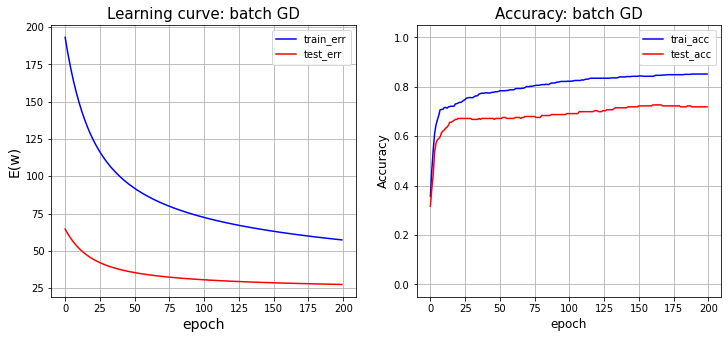

【SGD】
Training accuracy: 0.8515625
Training loss: 57.50040573874955
Testing accuracy:     0.71875
Testing loss: 57.50040573874955


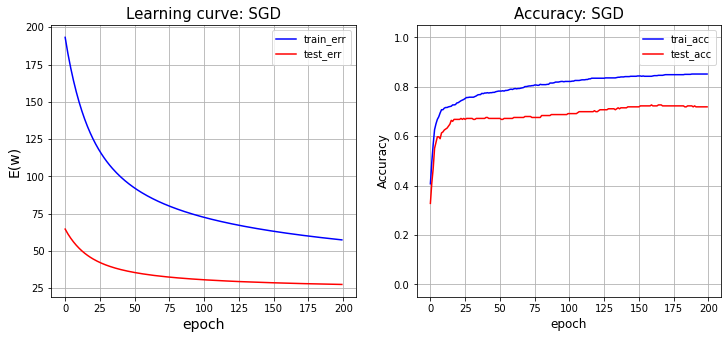

【mini-batch SGD】
Training accuracy: 0.8515625
Training loss: 57.49421593218013
Testing accuracy:     0.71875
Testing loss: 57.49421593218013


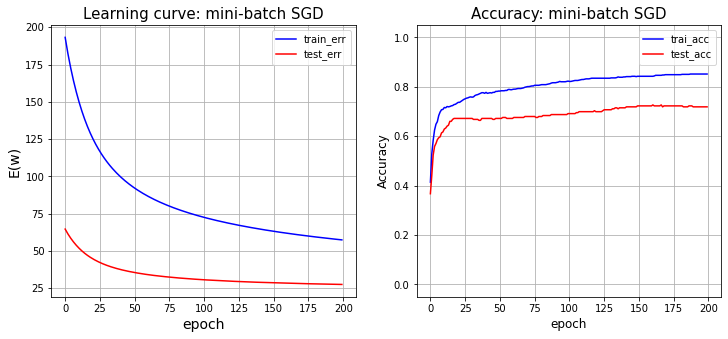

In [13]:
Case = ['batch GD','SGD','mini-batch SGD']
# parameters for training    
max_iter = 200
batch_size = [768, 1, 96] # batch GD, SGD and mini-batch SGD
iteration = [1, 768, 8]
learning_rate = 0.00008




# Iterative training
for case in range(len(batch_size)):
  # loss and accuracy
  train_loss = []
  test_loss = []
  train_acc = []
  test_acc = []
  # Zero initialization for weights 
  w = np.zeros([class_Num, feature_Size]) 

  for epoch in range(max_iter):
      # Random shuffle in each epoch
      X_train, Y_train = _shuffle(x_train, y_train)
      #X_train, Y_train = x_train, y_train
          
      # training
      for i in range(int(iteration[case])):
        X = X_train[i*batch_size[case]:(i+1)*batch_size[case], :]
        Y = Y_train[i*batch_size[case]:(i+1)*batch_size[case],:]
        
        # trainign
        tmp_train = np.dot(w, X.T)
        # softmax
        new_y = np.exp(tmp_train) / np.sum(np.exp(tmp_train), axis=0)
        #update weight
        w = w + learning_rate * np.dot((Y.T- new_y), X) 
      


      # Compute loss and accuracy of training set and testing set
      y_train_pred = np.dot(w, x_train.T)
      new_y_train = np.exp(y_train_pred) / np.sum(np.exp(y_train_pred), axis=0)
      train_err = -np.sum(y_train.T * np.log(new_y_train))/new_y_train.shape[0]

      train_acc.append(accuracy(y_train, new_y_train))
      train_loss.append(train_err)

      y_test_pred = np.dot(w, x_test.T)
      new_y_test = np.exp(y_test_pred) / np.sum(np.exp(y_test_pred), axis=0)
      test_err = -np.sum(y_test.T * np.log(new_y_test))/new_y_test.shape[0]

      test_acc.append(accuracy(y_test, new_y_test))
      test_loss.append(test_err)


  print('【'+ str(Case[case]) + '】')
  print('Training accuracy: ' + str(train_acc[epoch-1]))
  print('Training loss: ' + str(train_loss[epoch-1]))
  print('Testing accuracy:     ' + str(test_acc[epoch-1]))
  print('Testing loss: ' + str(train_loss[epoch-1]))
  plt.figure(figsize=(12,5))
  plt.subplot(121); plt.title('Learning curve: ' + str(Case[case]) , fontsize = 15)
  plt.xlabel('epoch', fontsize = 14); plt.ylabel('E(w)', fontsize = 14)
  plt.plot(range(0, epoch+1), train_loss, c='b', label='train_err')
  plt.plot(range(0, epoch+1), test_loss, c='r', label='test_err')
  plt.legend(loc=0)
  plt.grid(True)
  plt.subplot(122); plt.title('Accuracy: ' + str(Case[case]) , fontsize = 15)
  plt.xlabel('epoch', fontsize = 12); plt.ylabel('Accuracy', fontsize = 12)
  plt.plot(range(0, epoch+1), train_acc, c='b', label='trai_acc')
  plt.plot(range(0, epoch+1), test_acc, c='r', label='test_acc')
  plt.ylim(-0.05, 1.05)
  plt.legend(loc=0)
  plt.grid(True)
  plt.show()

# 2 Gaussian Process for Regression

In [14]:
data_x = pd.read_csv("/content/drive/MyDrive/ML/hw2/gaussian_process_data/x.csv",header = None)
data_t = pd.read_csv("/content/drive/MyDrive/ML/hw2/gaussian_process_data/t.csv",header = None)
data_x = np.array(data_x)
data_t = np.array(data_t)


x_train = data_x[0:150]
x_test = data_x[150:]
t_train = data_t[0:150]
t_test = data_t[150:]

print("training data")
print(x_train.shape)
print(t_train.shape)
print("testing data")
print(t_train.shape)
print(t_test.shape)

training data
(150, 1)
(150, 1)
testing data
(150, 1)
(150, 1)


In [15]:
class GP():
    def __init__(self, thetas, X_train, Y_train, sigma_y = 1):
        self.thetas = np.asarray(thetas).astype(float)
        self.X_train = X_train
        self.Y_train = Y_train
        self.Kernel = self.kernel(self.X_train, self.X_train) + sigma_y**2 * np.eye(len(self.X_train))
        
    def kernel(self, xn, xm):
        tmp = np.sum(xn**2, 1).reshape(-1, 1) + np.sum(xm**2, 1) - 2 * np.dot(xn, xm.T)
        return  self.thetas[0] * np.exp(-0.5*self.thetas[1]*tmp) + self.thetas[2] + self.thetas[3]*xn.dot(xm.T)
        
    def predict(self, X_s, sigma_y = 1):
        K1 = self.kernel(self.X_train, X_s) # K(x',x)
        K2 = self.kernel(X_s, X_s)+ sigma_y**2 * np.eye(len(X_s)) # K(x',x')
        inv = np.linalg.pinv(self.Kernel)
        mu = K1.T.dot(inv).dot(self.Y_train)
        cov = K2 - K1.T.dot(inv).dot(K1)
        return mu,cov
    
    def RMS(self, x, t):
        mean, var = self.predict(x)
        return np.sqrt(np.sum((mean-t)**2)/len(x))
        
    def ard(self, lr):
        sqdist = np.sum(self.X_train**2, 1).reshape(-1, 1) + np.sum(self.X_train**2, 1) - 2 * np.dot(self.X_train, self.X_train.T)
        theta0 = np.exp(-0.5*self.thetas[1]*sqdist)
        theta1 = self.thetas[0] * np.exp(-0.5*self.thetas[1]*sqdist) * (-0.5*sqdist)
        theta2 = np.ones((len(self.X_train),len(self.X_train)))
        theta3 = self.X_train.dot(self.X_train.T)
        theta = [theta0,theta1,theta2,theta3]
        epoch = 0
        while epoch<30:
            update = np.zeros((4))
            for i in range(4):
                update[i] = -0.5*np.trace(np.linalg.pinv(self.Kernel).dot(theta[i])) + 0.5*self.Y_train.T.dot(np.linalg.pinv(self.Kernel)).dot(theta[i]).dot(np.linalg.pinv(self.Kernel)).dot(self.Y_train)
            self.thetas += lr*update
            self.Kernel = self.kernel(self.X_train, self.X_train) + 1**2 * np.eye(len(self.X_train))
            epoch += 1

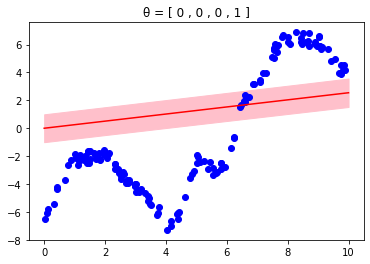

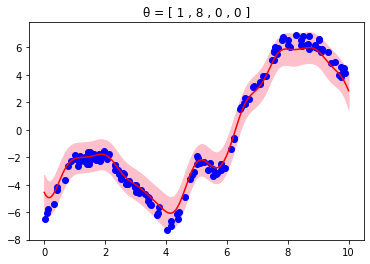

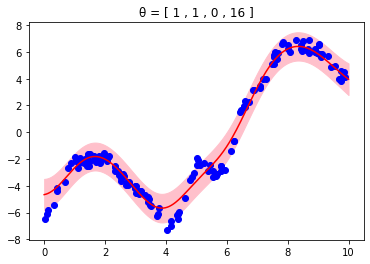

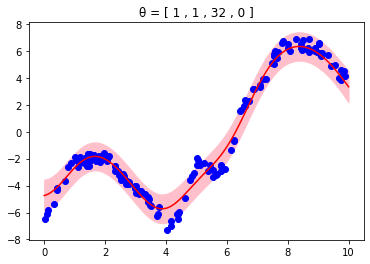

【ＲＭＳ】
theta              train              test              
[0, 0, 0, 1]   4.082716846775838  3.9326169919139913 
[1, 8, 0, 0]   0.4696178461099706 0.49302745582331897 
[1, 1, 0, 16]   0.6044969015610573 0.5809786110397732 
[1, 1, 32, 0]   0.6024902451850228 0.5866270617533015 


In [16]:
theta = [[0,0,0,1],[1,8,0,0],[1,1,0,16],[1,1,32,0]]
rms = []
for i in theta:
    gp = GP(i,x_train, t_train)
    line = np.linspace(0.,10.,300).reshape(300,1)
    mx, vx = gp.predict(line)
    vx = np.array([vx[j][j] for j in range(len(vx))])
    rms.append([gp.RMS(x_train, t_train),gp.RMS(x_test, t_test)])
    plt.plot(x_train, t_train,'bo')
    plt.plot(line, mx, linestyle = '-', color = 'red')
    plt.fill_between(line.reshape(-1), (mx.reshape(-1)-vx), (mx.reshape(-1)+vx), color = 'pink')
    plt.title('θ = [ '+str(i[0])+' , '+str(i[1])+' , '+str(i[2])+' , '+str(i[3])+' ]')
    plt.show()
    


print("【ＲＭＳ】")
print ("{:<18} {:<18} {:<18}".format('theta','train','test'))
i=0
for v in rms:
    train, test = v
    print(theta[i],end="   ")
    print ("{:<18} {:<18} ".format( train, test))
    i=i+1

## Automatic Relevance Determination

RMS train 0.2608333529836872
RMS test 0.3162420963172259


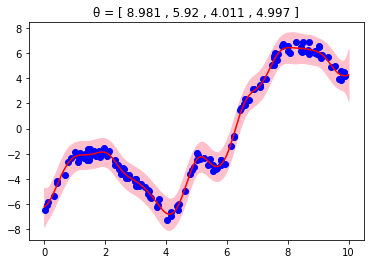

In [17]:
theta = [9.,6.,4.,5.]
gp = GP(theta,x_train, t_train)
gp.ard(0.001)
print("RMS train",gp.RMS(x_train, t_train))
print("RMS test",gp.RMS(x_test, t_test))
line = np.linspace(0.,10.,300).reshape(300,1)
mx, vx = gp.predict(line)
vx = np.array([vx[j][j] for j in range(len(vx))])
plt.plot(x_train, t_train,'bo')
plt.plot(line, mx, linestyle = '-', color = 'red')
plt.fill_between(line.reshape(-1), (mx.reshape(-1)-vx), (mx.reshape(-1)+vx), color = 'pink')
plt.title('θ = [ '+str(round(gp.thetas[0],3))+' , '+str(round(gp.thetas[1],3))+' , '+str(round(gp.thetas[2],3))+' , '+str(round(gp.thetas[3],3))+' ]')
plt.show()